![](../images/rivacon_frontmark_combined_header.png)

# European Plain Vanilla Option

In [2]:
import rivapy
import datetime as dt
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
import random
import pandas as pd

%load_ext autoreload
%autoreload 2
#the next line is a jupyter internal command to show the matplotlib graphs within the notebook
%matplotlib inline

## Option Pricing Using *rivapy* European Vanilla Specification

### Create the necessary market data

As a first step, we need to create the market data necessary to conduct the valuation. Therefore, we need to construct a *discount-*, *funding-* and *borrowing curve*, a *forward-curve* as well as a *volatility surface*.

#### Create a discount-, funding-, and borrowing curve

In [3]:
refdate = dt.datetime(2021,1,1,0,0,0)
days_to_maturity = [1, 180, 365, 720, 3*365, 4*365, 10*365]
dates = [refdate + dt.timedelta(days=d) for d in days_to_maturity]
# discount factors from constant rate
disc_rate = 0.05
dc = rivapy.marketdata.DiscountCurve("DC", refdate, dates, 
                                            [math.exp(-d/365.0*disc_rate) for d in days_to_maturity])
borrow_rate = 0.02
bc = rivapy.marketdata.DiscountCurve("BC", refdate, dates, 
                                            [math.exp(-d/365.0*borrow_rate) for d in days_to_maturity])

funding_rate = 0.05
fc = rivapy.marketdata.DiscountCurve("FC", refdate, dates, 
                                            [math.exp(-d/365.0*funding_rate) for d in days_to_maturity])

#### Create a dividend table

In [4]:
refdate = dt.datetime(2021,1,1,0,0,0)
ex_dates =  [refdate + dt.timedelta(days=i) for i in [365, 2*365, 3*365, 4*365]]
pay_dates = [d + dt.timedelta(days=2) for d in ex_dates]
tax_factors = [1.0, 1.0, 1.0, 1.0]
div_yield = [0, 0.0, 0.02, 0.02]
div_cash = [2.5, 2.5, 1.5, 1.5]
div_table = rivapy.marketdata.DividendTable('DIV', refdate, ex_dates, pay_dates, div_yield, div_cash, tax_factors)

#### Create a forward curve

To ensure comparability with the results from the Black-Scholes-Merton model, we assume a non dividend paying stock.

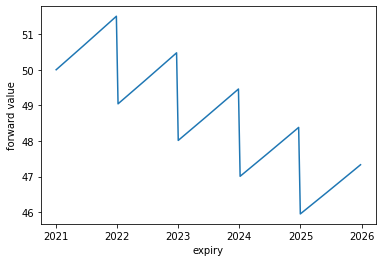

In [5]:
# Creation of a Forward curve
spot = 50.0
forward_curve = rivapy.marketdata.EquityForwardCurve(spot, fc, bc, div_table)
forward_curve.plot(days_end=5*365)

#### Create a volatility surface

In order to compare the results with the Black-Scholes-Merton model above, we use a flat volatillity surface.

In [6]:
vol_surf = rivapy.marketdata.VolatilitySurfaceFlat('TEST_SURFACE', refdate, forward_curve, 0.3)

### Setup the specification

The rivapy European Vanilla Specification requires the following mandatory arguments:
- object id (str)
- type ('CALL','PUT')
- expiry (datetime)
- strike (float)

The following arguments must only be set when...??
- issuer
- securitization level
- currency
- underlying id
- share ratio
- ex settle
- trade settle

[Beschreibung warum relevant]Although the arguments *object id*, *issuer*, *securitization level* and the *underlying id* are not relevant for the pricing process, they nevertheless have to be set. Hence, we have to input valid strings for these arguments. Optional arguments are the *share ratio*, *holidays*, *ex settle* and *trade settle*.

Referring to the Black-Scholes-Merton model, we consequently provided the model already with the the *option type*, the *expiry* $T$ and the *strike price* $K$. Thus, $S_0$, $r$ and $\sigma$ have not been set yet. This data has been defined in the previous steps by creating the necessary market data.

The *Back76PricingData* requires a discount curve, pricing parameter, a pricing specification and a volatility surface. Furthermore, we need to provide a valuation date and set the pricing request. The underlying's spot price $S_0$ is provided through the forward curve which is contained in the volatility surface which, of course, also contains the volatility $\sigma$. $r$ is contained in the provided discount curve. 

In [7]:
issuer = 'DBK'
seclevel = 'COLLATERALIZED'
currency = 'EUR'
tpe = 'CALL' # Change to 'PUT' if you want to calculate the price of an european put option.
expiry = refdate + dt.timedelta(days=365)
strike = 50
spec = rivapy.instruments.EuropeanVanillaSpecification('Test_call', tpe, expiry, strike, 
                                                       issuer = issuer, sec_lvl = seclevel, curr='EUR',udl_id='ADS',share_ratio = 1)

### Setup the pricing data

In [8]:
prdata = rivapy.pricing.Black76PricingData(val_date = refdate, 
                                           spec = spec, 
                                           discount_curve = dc, 
                                           vol_surface = vol_surf, 
                                           pricing_request=(rivapy.pricing.ResultType.DELTA, 
                                                            rivapy.pricing.ResultType.GAMMA))

In [9]:
prdata1 = rivapy.pricing.Black76PricingData(val_date = refdate, 
                                           spec = spec, 
                                           discount_curve = dc, 
                                           vol_surface = vol_surf, 
                                           pricing_request=(rivapy.pricing.ResultType.PRICE))

### Calculation of an option price using the pyvacon European Vanilla Specification

After all necessary information has been set, the price of the option can be calculated using the *rivapy.pricing.price* function.

In [10]:
price = rivapy.pricing.price(prdata)
price.getPrice()
# delta = price.getDeltas()
# price.getDelta1D()

4.564237182376621

In [11]:
# delta.values()

### Exercises - rivapy European Vanilla Specification

- Calculate the price of an European put option using the rivapy European Vanilla Specification.

- Modify the dividend table to see how dividends impact the option price.

- Calculate the price of an European call option using a discount curve with a non-constant discount rate.

- Use a different volatility model.

## General Remarks

### Implied volatility

Since the volatility in the option pricing formulas cannot be directly observed, one usually works with implied volatilities. Implied volatilities are the volatilities implied by option prices observed in the market. As it is not possible to invert the Black-Scholes-Merton or Black-76 formulas so that the volatility is expressed as a function of the other parameters, one needs to use an interactive search procedure.